# Mask R-CNN Demo

* 使用预先训练的模型来检测和分割模型的快速介绍

In [1]:
# Using Tensorflow-2.4.x
import tensorflow as tf
try:
    tf_gpus = tf.config.list_physical_devices('GPU')
    for gpu in tf_gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except:
    pass

import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# 项目根目录
ROOT_DIR = os.path.abspath("../")

# 导入 Mask RCNN
sys.path.append(ROOT_DIR)  # 找到本地版本的库
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# 导入 COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # 找到本地版本
import coco

%matplotlib inline 

# 要保存日志和训练的模型的目录
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# 训练权重文件的本地路径
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# 如果需要，从发行版本下载COCO训练的权重
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# 要运行检测的图像目录
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

## Configurations

* 我们将使用MS-COCO数据集训练我们的模型，这个模型配置在 ```CocoConfig``` 类 ```coco.py```
* 为了推理，修改配置以适合任务，为此子类别需更改所需的属性并覆盖原 ```CocoConfig``` .

In [2]:
class InferenceConfig(coco.CocoConfig):
    # 设置 batch size = 1 因为我们会运行一次推断
    # Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Create Model and Load Trained Weights

In [3]:
# 在推理模式下创建模型对象.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# 导入 MS-COCO 的训练权重
model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
Use fn_output_signature instead


## Class Names


* 该模型对对象进行分类并返回 class IDs, 这些ID 是标识每个类的整数值. 一些数据集为其类分配整数值，而某些数据集则没有. 例如，在MS-COCO数据集中，“person”类为1，“teddy bear”为88. IDs 通常是顺序的，但并非总是如此. 例如，COCO数据集具有与类ID 70和72关联的类，但没有与类ID 71关联的类。


* 为了提高一致性，并支持同时训练来自多个源的数据，我们的 ```Dataset``` 类将其自己的顺序整数ID分配给每个类. 例如，如果您使用我们的“ Dataset”类加载COCO数据集，则“ person”类的ID为1（就像COCO一样），“teddy bear”类为78（与COCO不同）. 将类ID映射到类名称时，请记住这一点. 


* 要获取类名列表，您需要加载数据集，然后使用像这样的```class_names```属性
```
    # Load COCO dataset
    dataset = coco.CocoDataset()
    dataset.load_coco(COCO_DIR, "train")
    dataset.prepare()

    # Print class names
    print(dataset.class_names)
```


* 我们不想只为了运行此演示而下载COCO数据集，因此我们在下面包括了类名列表. 列表中类名称的索引表示其ID（第一类为0，第二类为1，第三类为2，...等）

In [5]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
# 列表中该类的索引是其 ID. 例如，要获取泰迪熊类的ID，请使用：class_names.index（'teddy bear'）
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']
# print(class_names.index('teddy bear'))  # 泰迪熊类别为78

## Run Object Detection

Processing 1 images
image                    shape: (415, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


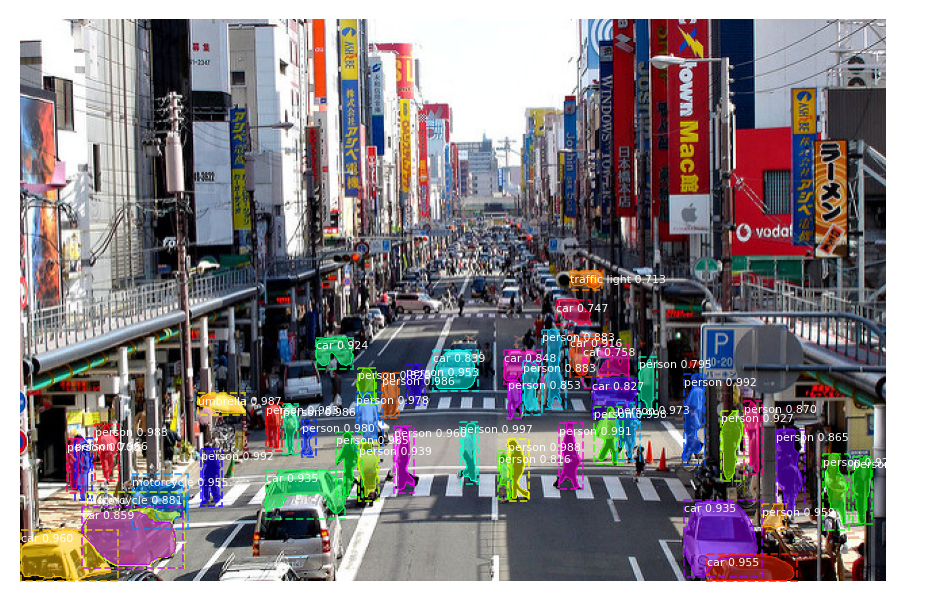

In [9]:
# Load a random image from the images folder
# 从images 文件夹加载随机图像
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# 运行 detection
results = model.detect([image], verbose=1)

# 可视化 results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])